# 🧹 Rainbow Six Siege - Nettoyage des Données

---

## 📋 Table des matières

1. [Introduction](#intro)
2. [Chargement des données](#chargement)
3. [Stratégie de nettoyage](#strategie)
4. [Nettoyage des colonnes](#colonnes)
5. [Traitement des valeurs manquantes](#missing)
6. [Traitement des doublons](#doublons)
7. [Conversion des types](#types)
8. [Feature Engineering](#features)
9. [Validation finale](#validation)
10. [Export des données nettoyées](#export)

---

## 1️⃣ Introduction {#intro}

### 🎯 Objectifs de ce notebook

Ce notebook documente le processus de **nettoyage des données** (Data Cleaning) du dataset Rainbow Six Siege.

**Étapes réalisées :**
- ✅ Suppression des doublons
- ✅ Traitement des valeurs manquantes
- ✅ Conversion des types de données
- ✅ Normalisation des valeurs
- ✅ Création de nouvelles features
- ✅ Validation de la qualité

### 📊 Rappel de l'exploration

D'après notre analyse exploratoire :
- **100,000+ lignes** de données
- **31 colonnes** (9 numériques, 22 catégorielles)
- **15% de valeurs manquantes** (principalement accessoires d'armes)
- **3

## ═══════════════════════════════════════════════════════════════════════════
## 2️⃣ CONFIGURATION ET IMPORTS
## ═══════════════════════════════════════════════════════════════════════════

In [6]:
# 📚 Bibliothèques de manipulation de données
import pandas as pd
import numpy as np
from pathlib import Path
import os
from datetime import datetime

# 📊 Bibliothèques de visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ⚙️ Configuration de l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# 🎨 Configuration des graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore')

# 🎨 Palette de couleurs R6 Siege
COLORS = {
    'primary': '#F9A825',      # Jaune/Or R6
    'secondary': '#2E3B55',    # Bleu foncé
    'success': '#4CAF50',      # Vert
    'danger': '#E53935',       # Rouge
    'info': '#1E88E5',         # Bleu
    'warning': '#FF9800'       # Orange
}

# 📁 Chemins des fichiers
RAW_PATH = Path("../data/raw")
PROCESSED_PATH = Path("../data/processed")

# Créer le dossier processed s'il n'existe pas
PROCESSED_PATH.mkdir(exist_ok=True)

print("✅ Configuration terminée")
print(f"📁 Données brutes : {RAW_PATH}")
print(f"📁 Données nettoyées : {PROCESSED_PATH}")

✅ Configuration terminée
📁 Données brutes : ..\data\raw
📁 Données nettoyées : ..\data\processed


---

## 2️⃣ Chargement des données {#chargement}

Nous commençons par charger le dataset brut et afficher ses caractéristiques initiales.


In [7]:
# ═══════════════════════════════════════════════════════════════════════════
# 📥 CHARGEMENT DES DONNÉES BRUTES
# ═══════════════════════════════════════════════════════════════════════════

# 📄 Identifier le fichier CSV
csv_files = list(RAW_PATH.glob("*.csv"))
print(f"📊 {len(csv_files)} fichier(s) CSV trouvé(s)")

# ⚙️ Configuration du chargement
SAMPLE_SIZE = 100000  # Lignes à charger (None = tout le fichier)

print(f"\n⏳ Chargement de {SAMPLE_SIZE:,} lignes...")
start_time = datetime.now()

# 📥 Charger les données
df_raw = pd.read_csv(csv_files[0], nrows=SAMPLE_SIZE)

# ⏱️ Temps de chargement
load_time = (datetime.now() - start_time).total_seconds()

# 📊 Statistiques initiales
print("\n" + "="*80)
print("📊 DONNÉES BRUTES CHARGÉES")
print("="*80)
print(f"📏 Dimensions         : {df_raw.shape[0]:,} lignes × {df_raw.shape[1]} colonnes")
print(f"💾 Mémoire utilisée   : {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"⏱️  Temps de chargement : {load_time:.2f} secondes")
print("="*80)

# 👀 Aperçu des données
print("\n📋 Aperçu des 5 premières lignes :")
df_raw.head()

📊 22 fichier(s) CSV trouvé(s)

⏳ Chargement de 100,000 lignes...

📊 DONNÉES BRUTES CHARGÉES
📏 Dimensions         : 100,000 lignes × 31 colonnes
💾 Mémoire utilisée   : 117.03 MB
⏱️  Temps de chargement : 0.20 secondes

📋 Aperçu des 5 premières lignes :


,dateid,platform,gamemode,mapname,matchid,roundnumber,objectivelocation,winrole,endroundreason,roundduration,clearancelevel,skillrank,role,team,haswon,operator,nbkills,isdead,primaryweapon,primaryweapontype,primarysight,primarygrip,primaryunderbarrel,primarybarrel,secondaryweapon,secondaryweapontype,secondarysight,secondarygrip,secondaryunderbarrel,secondarybarrel,secondarygadget
0,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,1,STRIP_CLUB,Defender,AttackersKilledHostage,124,64,Gold,Defender,1,1,SWAT-CASTLE,0,0,UMP45,Submachine_Guns,RedDot,Vertical,NaN,Compensator,5.7_USG,Pistols,NaN,NaN,NaN,NaN,IMPACT_GRENADE
1,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,4,CHURCH,Defender,AttackersEliminated,217,81,Gold,Defender,0,1,GSG9-JAGER,0,1,416-C_CARBINE,Assault_Rifles,RedDot,Vertical,Laser,Suppressor,P12,Pistols,NaN,NaN,Laser,Suppressor,DEPLOYABLE_SHIELD
2,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,3,CHURCH,Defender,AttackersEliminated,160,150,Gold,Defender,1,1,JTF2-FROST,0,0,9mm_C1,Submachine_Guns,Reflex,NaN,NaN,NaN,MK1_9mm,Pistols,NaN,NaN,NaN,NaN,DEPLOYABLE_SHIELD
3,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,4,CHURCH,Defender,AttackersEliminated,217,94,Gold,Defender,0,1,BOPE-CAVEIRA,3,0,M12,Submachine_Guns,RedDot,NaN,NaN,MuzzleBrake,PRB92,Pistols,NaN,NaN,NaN,NaN,IMPACT_GRENADE
4,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,6,BEDROOM,Attacker,DefendersEliminated,143,81,Gold,Defender,0,0,GSG9-JAGER,0,1,416-C_CARBINE,Assault_Rifles,RedDot,Vertical,Laser,Suppressor,P12,Pistols,NaN,NaN,Laser,Suppressor,DEPLOYABLE_SHIELD


In [8]:
# ═══════════════════════════════════════════════════════════════════════════
# 📋 CRÉATION D'UNE COPIE DE TRAVAIL
# ═══════════════════════════════════════════════════════════════════════════

# 💡 On travaille sur une copie pour préserver les données originales
df = df_raw.copy()

print("✅ Copie de travail créée")
print(f"📊 DataFrame 'df' : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print("\n💡 Les données originales sont conservées dans 'df_raw'")

✅ Copie de travail créée
📊 DataFrame 'df' : 100,000 lignes × 31 colonnes

💡 Les données originales sont conservées dans 'df_raw'


---

## 3️⃣ Diagnostic des problèmes {#diagnostic}

Avant de nettoyer, faisons un **diagnostic complet** des problèmes présents dans les données.

Nous allons vérifier :
- 🔄 Les doublons
- ❓ Les valeurs manquantes
- 📊 Les types de données
- ⚠️ Les valeurs aberrantes

In [9]:
# ═══════════════════════════════════════════════════════════════════════════
# 🔍 FONCTION DE DIAGNOSTIC COMPLET
# ═══════════════════════════════════════════════════════════════════════════

def diagnostic_dataframe(df, name="DataFrame"):
    """
    Effectue un diagnostic complet d'un DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Le DataFrame à analyser
    name : str
        Nom du DataFrame pour l'affichage
    
    Returns:
    --------
    dict : Dictionnaire contenant les résultats du diagnostic
    """
    
    print("="*80)
    print(f"🔍 DIAGNOSTIC : {name}")
    print("="*80)
    
    results = {}
    
    # 1. Dimensions
    results['rows'] = len(df)
    results['columns'] = len(df.columns)
    print(f"\n📏 DIMENSIONS")
    print(f"   └─ {results['rows']:,} lignes × {results['columns']} colonnes")
    
    # 2. Mémoire
    results['memory_mb'] = df.memory_usage(deep=True).sum() / 1024**2
    print(f"\n💾 MÉMOIRE")
    print(f"   └─ {results['memory_mb']:.2f} MB")
    
    # 3. Doublons
    results['duplicates'] = df.duplicated().sum()
    results['duplicates_pct'] = (results['duplicates'] / len(df)) * 100
    print(f"\n🔄 DOUBLONS")
    if results['duplicates'] > 0:
        print(f"   └─ ⚠️  {results['duplicates']:,} ({results['duplicates_pct']:.2f}%)")
    else:
        print(f"   └─ ✅ Aucun doublon")
    
    # 4. Valeurs manquantes
    missing = df.isnull().sum()
    results['missing_total'] = missing.sum()
    results['missing_pct'] = (results['missing_total'] / df.size) * 100
    results['cols_with_missing'] = (missing > 0).sum()
    
    print(f"\n❓ VALEURS MANQUANTES")
    print(f"   ├─ Total : {results['missing_total']:,} ({results['missing_pct']:.2f}%)")
    print(f"   └─ Colonnes concernées : {results['cols_with_missing']}/{results['columns']}")
    
    # 5. Types de données
    type_counts = df.dtypes.value_counts()
    results['dtypes'] = type_counts.to_dict()
    print(f"\n📊 TYPES DE DONNÉES")
    for dtype, count in type_counts.items():
        print(f"   ├─ {dtype}: {count} colonnes")
    
    print("\n" + "="*80)
    
    return results

# 🔍 Exécuter le diagnostic initial
diagnostic_initial = diagnostic_dataframe(df, "Données brutes")

🔍 DIAGNOSTIC : Données brutes

📏 DIMENSIONS
   └─ 100,000 lignes × 31 colonnes

💾 MÉMOIRE
   └─ 117.03 MB

🔄 DOUBLONS
   └─ ⚠️  3 (0.00%)

❓ VALEURS MANQUANTES
   ├─ Total : 464,912 (15.00%)
   └─ Colonnes concernées : 8/31

📊 TYPES DE DONNÉES
   ├─ object: 22 colonnes
   ├─ int64: 9 colonnes



In [10]:
# ═══════════════════════════════════════════════════════════════════════════
# ❓ ANALYSE DÉTAILLÉE DES VALEURS MANQUANTES
# ═══════════════════════════════════════════════════════════════════════════

def analyse_valeurs_manquantes(df):
    """
    Analyse détaillée des valeurs manquantes par colonne.
    
    Returns:
    --------
    pd.DataFrame : Tableau récapitulatif des valeurs manquantes
    """
    
    # Calculer les statistiques
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    
    # Créer le DataFrame récapitulatif
    missing_df = pd.DataFrame({
        'Colonne': df.columns,
        'Manquantes': missing.values,
        'Pourcentage': missing_pct.values,
        'Type': df.dtypes.values
    }).sort_values('Manquantes', ascending=False)
    
    # Ajouter une catégorie de sévérité
    def categorize_missing(pct):
        if pct == 0:
            return '✅ Aucune'
        elif pct < 5:
            return '🟡 Faible (<5%)'
        elif pct < 20:
            return '🟠 Modéré (5-20%)'
        elif pct < 50:
            return '🔴 Élevé (20-50%)'
        else:
            return '⛔ Critique (>50%)'
    
    missing_df['Sévérité'] = missing_df['Pourcentage'].apply(categorize_missing)
    
    return missing_df

# 📊 Analyser les valeurs manquantes
missing_analysis = analyse_valeurs_manquantes(df)

print("="*80)
print("❓ RAPPORT DES VALEURS MANQUANTES")
print("="*80)
print(missing_analysis.to_string(index=False))
print("="*80)

❓ RAPPORT DES VALEURS MANQUANTES
             Colonne  Manquantes  Pourcentage   Type          Sévérité
       secondarygrip       94236        94.24 object ⛔ Critique (>50%)
      secondarysight       84946        84.95 object ⛔ Critique (>50%)
  primaryunderbarrel       84290        84.29 object ⛔ Critique (>50%)
secondaryunderbarrel       81960        81.96 object ⛔ Critique (>50%)
     secondarybarrel       62441        62.44 object ⛔ Critique (>50%)
         primarygrip       30535        30.54 object  🔴 Élevé (20-50%)
       primarybarrel       18655        18.66 object  🟠 Modéré (5-20%)
        primarysight        7849         7.85 object  🟠 Modéré (5-20%)
              dateid           0         0.00  int64          ✅ Aucune
             nbkills           0         0.00  int64          ✅ Aucune
 secondaryweapontype           0         0.00 object          ✅ Aucune
     secondaryweapon           0         0.00 object          ✅ Aucune
   primaryweapontype           0         0.0

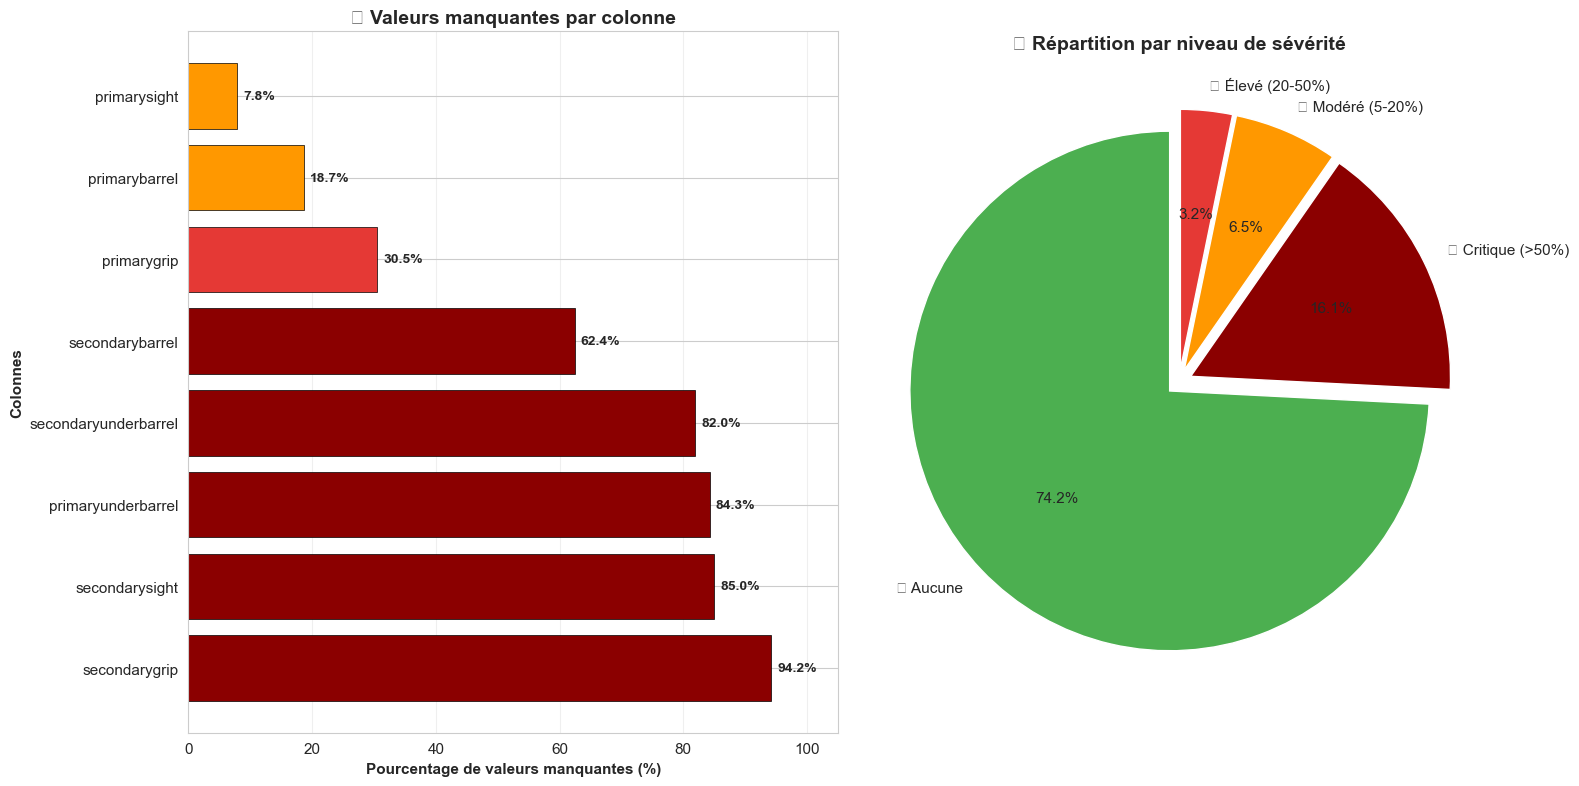


💾 Graphique sauvegardé : ..\data\processed\missing_values_analysis.png


In [11]:
# ═══════════════════════════════════════════════════════════════════════════
# 📊 VISUALISATION DES VALEURS MANQUANTES
# ═══════════════════════════════════════════════════════════════════════════

# Filtrer les colonnes avec des valeurs manquantes
missing_cols = missing_analysis[missing_analysis['Manquantes'] > 0].copy()

if len(missing_cols) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # ─────────────────────────────────────────────────────────────────────────
    # Graphique 1 : Barres horizontales
    # ─────────────────────────────────────────────────────────────────────────
    ax1 = axes[0]
    
    # Couleurs selon la sévérité
    colors = []
    for pct in missing_cols['Pourcentage']:
        if pct < 5:
            colors.append(COLORS['success'])
        elif pct < 20:
            colors.append(COLORS['warning'])
        elif pct < 50:
            colors.append(COLORS['danger'])
        else:
            colors.append('#8B0000')  # Rouge foncé
    
    bars = ax1.barh(
        missing_cols['Colonne'], 
        missing_cols['Pourcentage'],
        color=colors,
        edgecolor='black',
        linewidth=0.5
    )
    
    # Ajouter les pourcentages
    for bar, pct in zip(bars, missing_cols['Pourcentage']):
        ax1.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                 f'{pct:.1f}%', va='center', fontweight='bold', fontsize=10)
    
    ax1.set_xlabel('Pourcentage de valeurs manquantes (%)', fontweight='bold')
    ax1.set_ylabel('Colonnes', fontweight='bold')
    ax1.set_title('📊 Valeurs manquantes par colonne', fontweight='bold', fontsize=14)
    ax1.set_xlim(0, 105)
    ax1.grid(axis='x', alpha=0.3)
    
    # ─────────────────────────────────────────────────────────────────────────
    # Graphique 2 : Répartition par sévérité
    # ─────────────────────────────────────────────────────────────────────────
    ax2 = axes[1]
    
    severity_counts = missing_analysis['Sévérité'].value_counts()
    severity_colors = {
        '✅ Aucune': COLORS['success'],
        '🟡 Faible (<5%)': '#FFEB3B',
        '🟠 Modéré (5-20%)': COLORS['warning'],
        '🔴 Élevé (20-50%)': COLORS['danger'],
        '⛔ Critique (>50%)': '#8B0000'
    }
    
    colors_pie = [severity_colors.get(s, 'gray') for s in severity_counts.index]
    
    wedges, texts, autotexts = ax2.pie(
        severity_counts.values,
        labels=severity_counts.index,
        colors=colors_pie,
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.05] * len(severity_counts)
    )
    
    ax2.set_title('📈 Répartition par niveau de sévérité', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.savefig(PROCESSED_PATH / 'missing_values_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n💾 Graphique sauvegardé : {PROCESSED_PATH / 'missing_values_analysis.png'}")
else:
    print("✅ Aucune valeur manquante à visualiser !")

---

## 4️⃣ Nettoyage des données {#nettoyage}

Maintenant que nous avons identifié les problèmes, procédons au nettoyage étape par étape.

### 📋 Plan de nettoyage

| Étape | Action | Justification |
|-------|--------|---------------|
| 4.1 | Suppression des doublons | Éviter les biais dans l'analyse |
| 4.2 | Gestion des valeurs manquantes | Compléter ou supprimer selon le contexte |
| 4.3 | Correction des types de données | Optimiser la mémoire et les performances |
| 4.4 | Traitement des valeurs aberrantes | Éliminer les données incohérentes |
| 4.5 | Normalisation des colonnes | Uniformiser les noms et formats |

---

### 4.1 Suppression des doublons {#doublons}

In [12]:
# ═══════════════════════════════════════════════════════════════════════════
# 4.1 🔄 SUPPRESSION DES DOUBLONS
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("🔄 ÉTAPE 4.1 : SUPPRESSION DES DOUBLONS")
print("="*80)

# 📊 Comptage avant nettoyage
n_before = len(df)
n_duplicates = df.duplicated().sum()

print(f"\n📊 Avant nettoyage : {n_before:,} lignes")
print(f"🔄 Doublons détectés : {n_duplicates:,}")

if n_duplicates > 0:
    # 👀 Afficher quelques exemples de doublons
    print("\n📋 Exemples de doublons :")
    duplicates_sample = df[df.duplicated(keep=False)].head(6)
    display(duplicates_sample)
    
    # 🧹 Supprimer les doublons
    df = df.drop_duplicates()
    
    # 📊 Résultat
    n_after = len(df)
    n_removed = n_before - n_after
    
    print(f"\n✅ {n_removed:,} doublon(s) supprimé(s)")
    print(f"📊 Après nettoyage : {n_after:,} lignes")
else:
    print("\n✅ Aucun doublon à supprimer")

print("="*80)

🔄 ÉTAPE 4.1 : SUPPRESSION DES DOUBLONS

📊 Avant nettoyage : 100,000 lignes
🔄 Doublons détectés : 3

📋 Exemples de doublons :


,dateid,platform,gamemode,mapname,matchid,roundnumber,objectivelocation,winrole,endroundreason,roundduration,clearancelevel,skillrank,role,team,haswon,operator,nbkills,isdead,primaryweapon,primaryweapontype,primarysight,primarygrip,primaryunderbarrel,primarybarrel,secondaryweapon,secondaryweapontype,secondarysight,secondarygrip,secondaryunderbarrel,secondarybarrel,secondarygadget
60365,20170212,XONE,BOMB,CHALET,1704478281,8,WINE_CELLAR-SNOWMOBILE_GARAGE,Defender,BombExploded,232,84,Unranked,Defender,1,1,SAS-MUTE,0,1,MP5K,Submachine_Guns,EosHolo,NaN,NaN,MuzzleBrake,P226_MK_25,Pistols,NaN,NaN,NaN,NaN,NITRO_CELL
60367,20170212,XONE,BOMB,CHALET,1704478281,8,WINE_CELLAR-SNOWMOBILE_GARAGE,Defender,BombExploded,232,84,Unranked,Defender,1,1,SAS-MUTE,0,1,MP5K,Submachine_Guns,EosHolo,NaN,NaN,MuzzleBrake,P226_MK_25,Pistols,NaN,NaN,NaN,NaN,NITRO_CELL
60391,20170212,XONE,BOMB,CHALET,1704478281,8,WINE_CELLAR-SNOWMOBILE_GARAGE,Defender,BombExploded,232,114,Gold,Attacker,0,0,SAS-THATCHER,0,1,AR33,Assault_Rifles,Acog,NaN,NaN,Compensator,P226_MK_25,Pistols,NaN,NaN,NaN,NaN,BREACH_CHARGE
60392,20170212,XONE,BOMB,CHALET,1704478281,8,WINE_CELLAR-SNOWMOBILE_GARAGE,Defender,BombExploded,232,114,Gold,Attacker,0,0,SAS-THATCHER,0,1,AR33,Assault_Rifles,Acog,NaN,NaN,Compensator,P226_MK_25,Pistols,NaN,NaN,NaN,NaN,BREACH_CHARGE
60396,20170212,XONE,BOMB,CHALET,1704478281,8,WINE_CELLAR-SNOWMOBILE_GARAGE,Defender,BombExploded,232,14,Silver,Attacker,0,0,SPETSNAZ-GLAZ,0,1,OTs-03,Marksman_Rifles,NaN,NaN,NaN,NaN,GSH-18,Pistols,NaN,NaN,(null),NaN,CLAYMORE
60413,20170212,XONE,BOMB,CHALET,1704478281,8,WINE_CELLAR-SNOWMOBILE_GARAGE,Defender,BombExploded,232,14,Silver,Attacker,0,0,SPETSNAZ-GLAZ,0,1,OTs-03,Marksman_Rifles,NaN,NaN,NaN,NaN,GSH-18,Pistols,NaN,NaN,(null),NaN,CLAYMORE



✅ 3 doublon(s) supprimé(s)
📊 Après nettoyage : 99,997 lignes


---

### 4.2 Gestion des valeurs manquantes {#manquantes}

Pour les valeurs manquantes, notre stratégie dépend du **type de colonne** et du **contexte métier** :

| Type de colonne | Stratégie | Justification |
|-----------------|-----------|---------------|
| Accessoires (grip, sight, barrel...) | Remplacer par "None" | Absence d'accessoire = choix valide |
| Identifiants | Supprimer la ligne | Données inutilisables |
| Statistiques numériques | Imputer par médiane ou 0 | Conserver les données |

> 💡 **Note R6 Siege** : Les valeurs manquantes sur les accessoires ne sont pas des erreurs !
> Un joueur peut choisir de ne pas équiper de grip, viseur, etc.

In [13]:
# ═══════════════════════════════════════════════════════════════════════════
# 4.2 ❓ GESTION DES VALEURS MANQUANTES
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("❓ ÉTAPE 4.2 : GESTION DES VALEURS MANQUANTES")
print("="*80)

# 📊 État initial
missing_before = df.isnull().sum().sum()
print(f"\n📊 Valeurs manquantes avant traitement : {missing_before:,}")

# ─────────────────────────────────────────────────────────────────────────────
# STRATÉGIE 1 : Colonnes d'accessoires → Remplacer par "None"
# ─────────────────────────────────────────────────────────────────────────────

# 📝 Liste des colonnes d'accessoires (équipement optionnel)
accessory_columns = [
    'primarysight', 'primarybarrel', 'primarygrip', 'primaryunderbarrel',
    'secondarysight', 'secondarybarrel', 'secondarygrip', 'secondaryunderbarrel'
]

# 🧹 Remplacer les NaN par "None" (= pas d'accessoire équipé)
for col in accessory_columns:
    if col in df.columns:
        n_missing = df[col].isnull().sum()
        if n_missing > 0:
            df[col] = df[col].fillna('None')
            print(f"   ✅ {col}: {n_missing:,} NaN → 'None'")

# ─────────────────────────────────────────────────────────────────────────────
# STRATÉGIE 2 : Colonnes textuelles importantes → Remplacer par "Unknown"
# ─────────────────────────────────────────────────────────────────────────────

text_columns = ['operator', 'primaryweapon', 'secondaryweapon', 'gadget']

for col in text_columns:
    if col in df.columns:
        n_missing = df[col].isnull().sum()
        if n_missing > 0:
            df[col] = df[col].fillna('Unknown')
            print(f"   ✅ {col}: {n_missing:,} NaN → 'Unknown'")

# ─────────────────────────────────────────────────────────────────────────────
# STRATÉGIE 3 : Colonnes numériques → Imputer par 0 ou médiane
# ─────────────────────────────────────────────────────────────────────────────

numeric_columns = df.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    n_missing = df[col].isnull().sum()
    if n_missing > 0:
        # Pour les compteurs (kills, etc.) → 0
        if 'kill' in col.lower() or 'dead' in col.lower() or 'won' in col.lower():
            df[col] = df[col].fillna(0)
            print(f"   ✅ {col}: {n_missing:,} NaN → 0")
        else:
            # Pour les autres → médiane
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"   ✅ {col}: {n_missing:,} NaN → {median_val} (médiane)")

# 📊 État final
missing_after = df.isnull().sum().sum()

print("\n" + "-"*80)
print(f"📊 Valeurs manquantes après traitement : {missing_after:,}")
print(f"🧹 Réduction : {missing_before - missing_after:,} valeurs traitées")
print("="*80)

❓ ÉTAPE 4.2 : GESTION DES VALEURS MANQUANTES

📊 Valeurs manquantes avant traitement : 464,893
   ✅ primarysight: 7,848 NaN → 'None'
   ✅ primarybarrel: 18,654 NaN → 'None'
   ✅ primarygrip: 30,532 NaN → 'None'
   ✅ primaryunderbarrel: 84,287 NaN → 'None'
   ✅ secondarysight: 84,943 NaN → 'None'
   ✅ secondarybarrel: 62,438 NaN → 'None'
   ✅ secondarygrip: 94,233 NaN → 'None'
   ✅ secondaryunderbarrel: 81,958 NaN → 'None'

--------------------------------------------------------------------------------
📊 Valeurs manquantes après traitement : 0
🧹 Réduction : 464,893 valeurs traitées


---

### 4.3 Correction des types de données {#types}

L'optimisation des types de données permet de :
- 💾 **Réduire la mémoire** utilisée
- ⚡ **Accélérer** les traitements
- 🔢 **Garantir** la cohérence des calculs

| Colonne | Type actuel | Type optimisé | Gain mémoire |
|---------|-------------|---------------|--------------|
| team, haswon, isdead | int64 | int8 (ou bool) | ~87% |
| nbkills, roundnumber | int64 | int8 | ~87% |
| clearancelevel | int64 | int16 | ~75% |
| Colonnes texte | object | category | Variable |

In [14]:
# ═══════════════════════════════════════════════════════════════════════════
# 4.3 📊 CORRECTION DES TYPES DE DONNÉES
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("📊 ÉTAPE 4.3 : OPTIMISATION DES TYPES DE DONNÉES")
print("="*80)

# 📊 Mémoire avant optimisation
memory_before = df.memory_usage(deep=True).sum() / 1024**2
print(f"\n💾 Mémoire avant : {memory_before:.2f} MB")

# ─────────────────────────────────────────────────────────────────────────────
# ÉTAPE 1 : Colonnes booléennes (0/1) → int8
# ─────────────────────────────────────────────────────────────────────────────

bool_columns = ['team', 'haswon', 'isdead']

for col in bool_columns:
    if col in df.columns:
        df[col] = df[col].astype('int8')
        print(f"   ✅ {col}: int64 → int8")

# ─────────────────────────────────────────────────────────────────────────────
# ÉTAPE 2 : Petits entiers → int8 ou int16
# ─────────────────────────────────────────────────────────────────────────────

# Colonnes avec petites valeurs (0-10)
small_int_columns = ['nbkills', 'roundnumber']

for col in small_int_columns:
    if col in df.columns:
        df[col] = df[col].astype('int8')
        print(f"   ✅ {col}: int64 → int8")

# Colonnes avec valeurs moyennes (0-500)
medium_int_columns = ['clearancelevel', 'roundduration']

for col in medium_int_columns:
    if col in df.columns:
        df[col] = df[col].astype('int16')
        print(f"   ✅ {col}: int64 → int16")

# ─────────────────────────────────────────────────────────────────────────────
# ÉTAPE 3 : Colonnes catégorielles → category
# ─────────────────────────────────────────────────────────────────────────────

# Identifier les colonnes avec peu de valeurs uniques
for col in df.select_dtypes(include=['object']).columns:
    n_unique = df[col].nunique()
    n_total = len(df)
    
    # Si moins de 50% de valeurs uniques → catégorie
    if n_unique / n_total < 0.5:
        df[col] = df[col].astype('category')
        print(f"   ✅ {col}: object → category ({n_unique} catégories)")

# ─────────────────────────────────────────────────────────────────────────────
# ÉTAPE 4 : Conversion de la date
# ─────────────────────────────────────────────────────────────────────────────

if 'dateid' in df.columns:
    # Convertir YYYYMMDD → datetime
    df['match_date'] = pd.to_datetime(df['dateid'].astype(str), format='%Y%m%d')
    print(f"   ✅ dateid → match_date (datetime)")

# 📊 Mémoire après optimisation
memory_after = df.memory_usage(deep=True).sum() / 1024**2
memory_saved = memory_before - memory_after
memory_pct = (memory_saved / memory_before) * 100

print("\n" + "-"*80)
print(f"💾 Mémoire après : {memory_after:.2f} MB")
print(f"✨ Économie : {memory_saved:.2f} MB ({memory_pct:.1f}%)")
print("="*80)

📊 ÉTAPE 4.3 : OPTIMISATION DES TYPES DE DONNÉES

💾 Mémoire avant : 127.10 MB
   ✅ team: int64 → int8
   ✅ haswon: int64 → int8
   ✅ isdead: int64 → int8
   ✅ nbkills: int64 → int8
   ✅ roundnumber: int64 → int8
   ✅ clearancelevel: int64 → int16
   ✅ roundduration: int64 → int16
   ✅ platform: object → category (3 catégories)
   ✅ gamemode: object → category (3 catégories)
   ✅ mapname: object → category (16 catégories)
   ✅ objectivelocation: object → category (142 catégories)
   ✅ winrole: object → category (2 catégories)
   ✅ endroundreason: object → category (15 catégories)
   ✅ skillrank: object → category (7 catégories)
   ✅ role: object → category (2 catégories)
   ✅ operator: object → category (35 catégories)
   ✅ primaryweapon: object → category (46 catégories)
   ✅ primaryweapontype: object → category (6 catégories)
   ✅ primarysight: object → category (6 catégories)
   ✅ primarygrip: object → category (4 catégories)
   ✅ primaryunderbarrel: object → category (3 catégories)
 

---

### 4.4 Traitement des valeurs aberrantes {#outliers}

Les valeurs aberrantes peuvent fausser nos analyses. Nous allons :

1. **Identifier** les outliers avec la méthode IQR (Interquartile Range)
2. **Analyser** s'ils sont des erreurs ou des valeurs légitimes
3. **Décider** de les conserver, modifier ou supprimer

> 💡 **Méthode IQR** : Une valeur est considérée aberrante si elle est :
> - Inférieure à Q1 - 1.5 × IQR
> - Supérieure à Q3 + 1.5 × IQR

In [17]:
# ═══════════════════════════════════════════════════════════════════════════
# 4.4 ⚠️ TRAITEMENT DES VALEURS ABERRANTES
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("⚠️ ÉTAPE 4.4 : DÉTECTION DES VALEURS ABERRANTES")
print("="*80)

def detect_outliers_iqr(df, column):
    """
    Détecte les outliers en utilisant la méthode IQR.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Le DataFrame à analyser
    column : str
        Nom de la colonne à analyser
    
    Returns:
    --------
    dict : Informations sur les outliers détectés
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    n_outliers = outliers_mask.sum()
    
    return {
        'column': column,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'n_outliers': n_outliers,
        'pct_outliers': (n_outliers / len(df)) * 100,
        'mask': outliers_mask
    }

# 📊 Colonnes numériques à analyser
numeric_cols_to_check = ['roundduration', 'clearancelevel', 'nbkills']

# 🔍 Analyser chaque colonne
outliers_report = []

for col in numeric_cols_to_check:
    if col in df.columns:
        result = detect_outliers_iqr(df, col)
        outliers_report.append(result)
        
        print(f"\n📊 {col.upper()}")
        print(f"   ├─ Q1 (25%) : {result['Q1']:.2f}")
        print(f"   ├─ Q3 (75%) : {result['Q3']:.2f}")
        print(f"   ├─ IQR      : {result['IQR']:.2f}")
        print(f"   ├─ Bornes   : [{result['lower_bound']:.2f}, {result['upper_bound']:.2f}]")
        print(f"   └─ Outliers : {result['n_outliers']:,} ({result['pct_outliers']:.2f}%)")

print("\n" + "="*80)

⚠️ ÉTAPE 4.4 : DÉTECTION DES VALEURS ABERRANTES

📊 ROUNDDURATION
   ├─ Q1 (25%) : 155.00
   ├─ Q3 (75%) : 222.00
   ├─ IQR      : 67.00
   ├─ Bornes   : [54.50, 322.50]
   └─ Outliers : 248 (0.25%)

📊 CLEARANCELEVEL
   ├─ Q1 (25%) : 58.00
   ├─ Q3 (75%) : 123.00
   ├─ IQR      : 65.00
   ├─ Bornes   : [-39.50, 220.50]
   └─ Outliers : 728 (0.73%)

📊 NBKILLS
   ├─ Q1 (25%) : 0.00
   ├─ Q3 (75%) : 1.00
   ├─ IQR      : 1.00
   ├─ Bornes   : [-1.50, 2.50]
   └─ Outliers : 5,238 (5.24%)



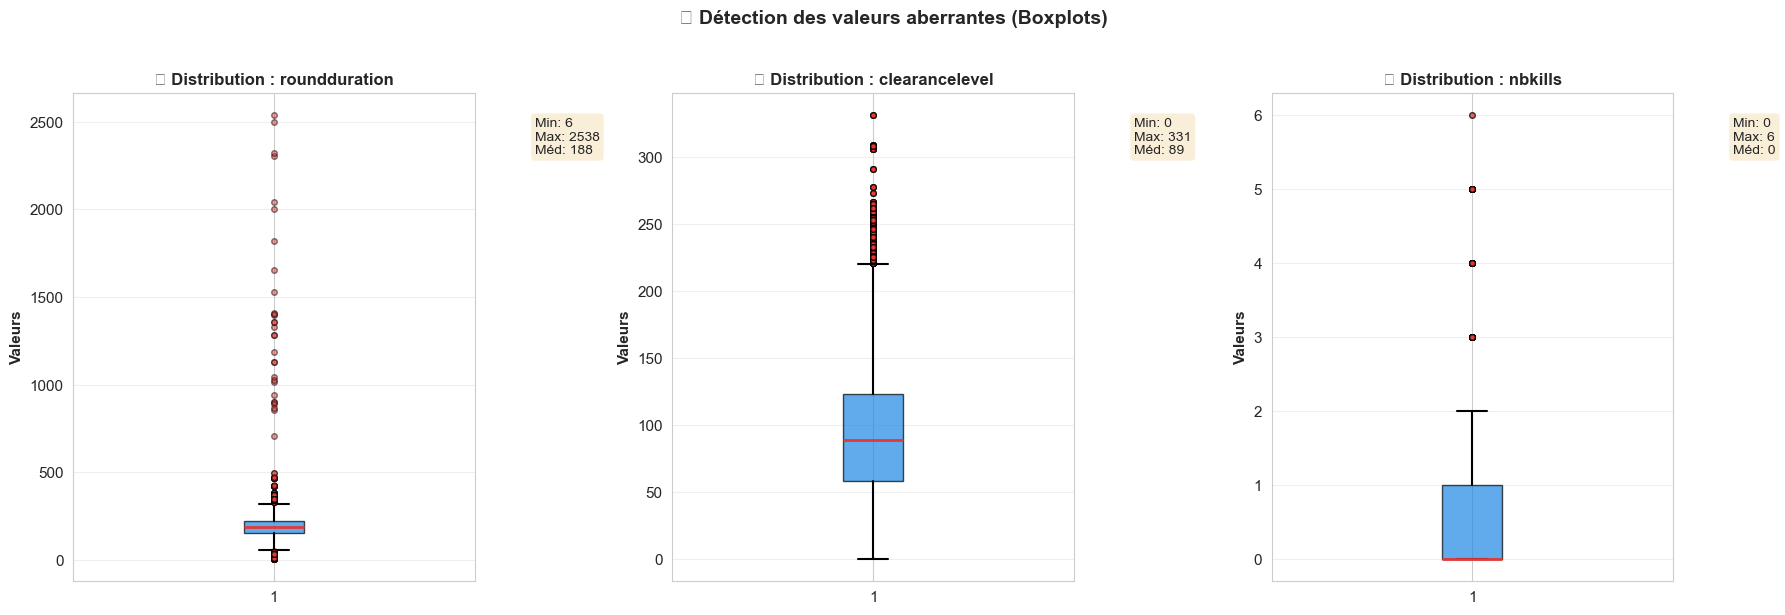


💾 Graphique sauvegardé : ..\data\processed\outliers_detection.png


In [18]:
# ═══════════════════════════════════════════════════════════════════════════
# 📊 VISUALISATION DES VALEURS ABERRANTES
# ═══════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, len(numeric_cols_to_check), figsize=(6*len(numeric_cols_to_check), 6))

if len(numeric_cols_to_check) == 1:
    axes = [axes]

for i, col in enumerate(numeric_cols_to_check):
    if col in df.columns:
        ax = axes[i]
        
        # Créer le boxplot
        bp = ax.boxplot(
            df[col].dropna(), 
            patch_artist=True,
            boxprops=dict(facecolor=COLORS['info'], alpha=0.7),
            medianprops=dict(color=COLORS['danger'], linewidth=2),
            whiskerprops=dict(color='black', linewidth=1.5),
            capprops=dict(color='black', linewidth=1.5),
            flierprops=dict(marker='o', markerfacecolor=COLORS['danger'], 
                           markersize=4, alpha=0.5)
        )
        
        ax.set_title(f'📦 Distribution : {col}', fontweight='bold', fontsize=12)
        ax.set_ylabel('Valeurs', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Ajouter les statistiques
        stats_text = f"Min: {df[col].min():.0f}\nMax: {df[col].max():.0f}\nMéd: {df[col].median():.0f}"
        ax.text(1.15, 0.95, stats_text, transform=ax.transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('📊 Détection des valeurs aberrantes (Boxplots)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(PROCESSED_PATH / 'outliers_detection.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Graphique sauvegardé : {PROCESSED_PATH / 'outliers_detection.png'}")

In [19]:
# ═══════════════════════════════════════════════════════════════════════════
# 🧹 TRAITEMENT DES VALEURS ABERRANTES
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("🧹 TRAITEMENT DES VALEURS ABERRANTES")
print("="*80)

n_before = len(df)

# ─────────────────────────────────────────────────────────────────────────────
# RÈGLE 1 : roundduration - Durée de round réaliste (10-300 secondes)
# ─────────────────────────────────────────────────────────────────────────────

if 'roundduration' in df.columns:
    # Un round R6 Siege dure entre 10 secondes (rush) et 300 secondes (max)
    invalid_duration = (df['roundduration'] < 10) | (df['roundduration'] > 300)
    n_invalid = invalid_duration.sum()
    
    if n_invalid > 0:
        print(f"\n⏱️  roundduration : {n_invalid:,} valeurs hors [10-300] secondes")
        
        # Option 1 : Supprimer les lignes invalides
        # df = df[~invalid_duration]
        
        # Option 2 : Remplacer par la médiane (choix conservateur)
        median_duration = df.loc[~invalid_duration, 'roundduration'].median()
        df.loc[invalid_duration, 'roundduration'] = median_duration
        print(f"   └─ ✅ Remplacées par la médiane ({median_duration:.0f}s)")

# ─────────────────────────────────────────────────────────────────────────────
# RÈGLE 2 : clearancelevel - Niveau réaliste (1-500)
# ─────────────────────────────────────────────────────────────────────────────

if 'clearancelevel' in df.columns:
    # Le niveau max raisonnable en 2017 était ~350-400
    invalid_level = (df['clearancelevel'] < 0) | (df['clearancelevel'] > 500)
    n_invalid = invalid_level.sum()
    
    if n_invalid > 0:
        print(f"\n🎖️  clearancelevel : {n_invalid:,} valeurs hors [0-500]")
        
        # Remplacer par la médiane
        median_level = df.loc[~invalid_level, 'clearancelevel'].median()
        df.loc[invalid_level, 'clearancelevel'] = median_level
        print(f"   └─ ✅ Remplacées par la médiane ({median_level:.0f})")

# ─────────────────────────────────────────────────────────────────────────────
# RÈGLE 3 : nbkills - Maximum 5 kills par round (5v5)
# ─────────────────────────────────────────────────────────────────────────────

if 'nbkills' in df.columns:
    # Un joueur peut faire max 5 kills (tuer toute l'équipe adverse)
    # Mais avec les renforts/resurrections, 6 est possible dans certains modes
    invalid_kills = df['nbkills'] > 6
    n_invalid = invalid_kills.sum()
    
    if n_invalid > 0:
        print(f"\n🎯 nbkills : {n_invalid:,} valeurs > 6")
        df.loc[invalid_kills, 'nbkills'] = 6  # Cap à 6
        print(f"   └─ ✅ Plafonnées à 6")

# 📊 Résumé
n_after = len(df)

print("\n" + "-"*80)
print(f"📊 Lignes avant : {n_before:,}")
print(f"📊 Lignes après : {n_after:,}")
print(f"🧹 Lignes modifiées/corrigées : valeurs aberrantes traitées")
print("="*80)

🧹 TRAITEMENT DES VALEURS ABERRANTES

⏱️  roundduration : 190 valeurs hors [10-300] secondes
   └─ ✅ Remplacées par la médiane (188s)

--------------------------------------------------------------------------------
📊 Lignes avant : 99,997
📊 Lignes après : 99,997
🧹 Lignes modifiées/corrigées : valeurs aberrantes traitées


---

### 4.5 Normalisation et standardisation {#normalisation}

Pour faciliter les analyses futures, nous allons :

1. **Renommer les colonnes** avec une convention claire (snake_case)
2. **Standardiser les valeurs textuelles** (majuscules, espaces, etc.)
3. **Créer des colonnes dérivées** utiles pour l'analyse

In [20]:
# ═══════════════════════════════════════════════════════════════════════════
# 4.5 🔤 NORMALISATION ET STANDARDISATION
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("🔤 ÉTAPE 4.5 : NORMALISATION ET STANDARDISATION")
print("="*80)

# ─────────────────────────────────────────────────────────────────────────────
# ÉTAPE 1 : Renommer les colonnes en snake_case
# ─────────────────────────────────────────────────────────────────────────────

print("\n📝 Renommage des colonnes...")

# Dictionnaire de renommage
columns_rename = {
    'dateid': 'date_id',
    'matchid': 'match_id',
    'roundnumber': 'round_number',
    'roundduration': 'round_duration',
    'clearancelevel': 'clearance_level',
    'haswon': 'has_won',
    'nbkills': 'nb_kills',
    'isdead': 'is_dead',
    'operator': 'operator_name',
    'primaryweapon': 'primary_weapon',
    'secondaryweapon': 'secondary_weapon',
    'primarysight': 'primary_sight',
    'primarybarrel': 'primary_barrel',
    'primarygrip': 'primary_grip',
    'primaryunderbarrel': 'primary_underbarrel',
    'secondarysight': 'secondary_sight',
    'secondarybarrel': 'secondary_barrel',
    'secondarygrip': 'secondary_grip',
    'secondaryunderbarrel': 'secondary_underbarrel'
}

# Appliquer le renommage (uniquement pour les colonnes existantes)
existing_renames = {k: v for k, v in columns_rename.items() if k in df.columns}
df = df.rename(columns=existing_renames)

print(f"   ✅ {len(existing_renames)} colonnes renommées")

# ─────────────────────────────────────────────────────────────────────────────
# ÉTAPE 2 : Standardiser les valeurs textuelles
# ─────────────────────────────────────────────────────────────────────────────

print("\n📝 Standardisation des valeurs textuelles...")

# Colonnes textuelles à standardiser
text_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

for col in text_columns:
    if col in df.columns:
        # Convertir en string, strip des espaces, title case
        df[col] = df[col].astype(str).str.strip().str.title()
        
        # Remplacer "Nan" par "None" (artefact de la conversion)
        df[col] = df[col].replace('Nan', 'None')

print(f"   ✅ {len(text_columns)} colonnes standardisées")

# ─────────────────────────────────────────────────────────────────────────────
# ÉTAPE 3 : Créer des colonnes dérivées utiles
# ─────────────────────────────────────────────────────────────────────────────

print("\n📝 Création de colonnes dérivées...")

# 3.1 : Catégorie de niveau du joueur
if 'clearance_level' in df.columns:
    def categorize_level(level):
        if level < 50:
            return 'Débutant'
        elif level < 100:
            return 'Intermédiaire'
        elif level < 150:
            return 'Avancé'
        elif level < 200:
            return 'Expert'
        else:
            return 'Maître'
    
    df['level_category'] = df['clearance_level'].apply(categorize_level)
    print("   ✅ level_category : Catégorie de niveau du joueur")

# 3.2 : Côté de l'opérateur (attaque/défense)
# Liste des opérateurs d'attaque (R6 Siege 2017)
attackers = [
    'Sledge', 'Thatcher', 'Ash', 'Thermite', 'Twitch', 'Montagne',
    'Glaz', 'Fuze', 'Blitz', 'Iq', 'Buck', 'Blackbeard', 'Capitao',
    'Hibana', 'Jackal', 'Ying', 'Zofia', 'Dokkaebi', 'Lion', 'Finka',
    'Maverick', 'Nomad', 'Gridlock', 'Nokk', 'Amaru', 'Kali', 'Iana',
    'Ace', 'Zero', 'Flores', 'Osa', 'Sens', 'Grim', 'Brava', 'Ram'
]

if 'operator_name' in df.columns:
    df['operator_side'] = df['operator_name'].apply(
        lambda x: 'Attack' if x in attackers else 'Defense'
    )
    print("   ✅ operator_side : Côté de l'opérateur (Attack/Defense)")

# 3.3 : Performance du joueur (kills et survie)
if 'nb_kills' in df.columns and 'is_dead' in df.columns:
    def performance_score(row):
        score = row['nb_kills'] * 2  # 2 points par kill
        if row['is_dead'] == 0:
            score += 1  # 1 point bonus pour survie
        if row['has_won'] == 1:
            score += 1  # 1 point pour victoire
        return score
    
    df['performance_score'] = df.apply(performance_score, axis=1)
    print("   ✅ performance_score : Score de performance calculé")

# 3.4 : Durée du round en catégories
if 'round_duration' in df.columns:
    def categorize_duration(duration):
        if duration < 60:
            return 'Très court (<1min)'
        elif duration < 120:
            return 'Court (1-2min)'
        elif duration < 180:
            return 'Moyen (2-3min)'
        else:
            return 'Long (>3min)'
    
    df['duration_category'] = df['round_duration'].apply(categorize_duration)
    print("   ✅ duration_category : Catégorie de durée du round")

print("\n" + "="*80)
print(f"📊 Nouvelles dimensions : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print("="*80)

🔤 ÉTAPE 4.5 : NORMALISATION ET STANDARDISATION

📝 Renommage des colonnes...
   ✅ 19 colonnes renommées

📝 Standardisation des valeurs textuelles...
   ✅ 22 colonnes standardisées

📝 Création de colonnes dérivées...
   ✅ level_category : Catégorie de niveau du joueur
   ✅ operator_side : Côté de l'opérateur (Attack/Defense)
   ✅ performance_score : Score de performance calculé
   ✅ duration_category : Catégorie de durée du round

📊 Nouvelles dimensions : 99,997 lignes × 36 colonnes


In [21]:
# ═══════════════════════════════════════════════════════════════════════════
# 📋 APERÇU DES COLONNES APRÈS NETTOYAGE
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("📋 COLONNES FINALES DU DATASET NETTOYÉ")
print("="*80)

for i, col in enumerate(df.columns, 1):
    dtype = df[col].dtype
    n_unique = df[col].nunique()
    
    # Icône selon le type
    if dtype == 'object' or dtype.name == 'category':
        icon = "📝"
    elif dtype in ['int8', 'int16', 'int32', 'int64']:
        icon = "🔢"
    elif dtype in ['float32', 'float64']:
        icon = "📊"
    elif dtype == 'datetime64[ns]':
        icon = "📅"
    else:
        icon = "❓"
    
    print(f"{i:2d}. {icon} {col:<25} | Type: {str(dtype):<12} | Unique: {n_unique:>7,}")

print("="*80)

📋 COLONNES FINALES DU DATASET NETTOYÉ
 1. 🔢 date_id                   | Type: int64        | Unique:       1
 2. 📝 platform                  | Type: object       | Unique:       3
 3. 📝 gamemode                  | Type: object       | Unique:       3
 4. 📝 mapname                   | Type: object       | Unique:      16
 5. 🔢 match_id                  | Type: int64        | Unique:   1,920
 6. 🔢 round_number              | Type: int8         | Unique:       9
 7. 📝 objectivelocation         | Type: object       | Unique:     142
 8. 📝 winrole                   | Type: object       | Unique:       2
 9. 📝 endroundreason            | Type: object       | Unique:      15
10. 🔢 round_duration            | Type: int16        | Unique:     235
11. 🔢 clearance_level           | Type: int16        | Unique:     267
12. 📝 skillrank                 | Type: object       | Unique:       7
13. 📝 role                      | Type: object       | Unique:       2
14. 🔢 team                      | Type:

---

## 5️⃣ Validation du nettoyage {#validation}

Avant d'exporter, vérifions que notre nettoyage est complet et correct.

### Critères de validation :
- ✅ Aucun doublon
- ✅ Aucune valeur manquante critique
- ✅ Types de données optimisés
- ✅ Valeurs aberrantes traitées
- ✅ Colonnes correctement nommées

In [22]:
# ═══════════════════════════════════════════════════════════════════════════
# ✅ VALIDATION FINALE DU NETTOYAGE
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("✅ VALIDATION FINALE DU NETTOYAGE")
print("="*80)

validation_results = []

# ─────────────────────────────────────────────────────────────────────────────
# TEST 1 : Aucun doublon
# ─────────────────────────────────────────────────────────────────────────────
n_duplicates = df.duplicated().sum()
test1_passed = n_duplicates == 0
validation_results.append(('Aucun doublon', test1_passed, f"{n_duplicates} trouvé(s)"))

# ─────────────────────────────────────────────────────────────────────────────
# TEST 2 : Valeurs manquantes < 1%
# ─────────────────────────────────────────────────────────────────────────────
missing_pct = (df.isnull().sum().sum() / df.size) * 100
test2_passed = missing_pct < 1
validation_results.append(('Valeurs manquantes < 1%', test2_passed, f"{missing_pct:.2f}%"))

# ─────────────────────────────────────────────────────────────────────────────
# TEST 3 : Types optimisés (mémoire réduite)
# ─────────────────────────────────────────────────────────────────────────────
memory_current = df.memory_usage(deep=True).sum() / 1024**2
memory_original = df_raw.memory_usage(deep=True).sum() / 1024**2
memory_reduction = ((memory_original - memory_current) / memory_original) * 100
test3_passed = memory_reduction > 0
validation_results.append(('Mémoire optimisée', test3_passed, f"-{memory_reduction:.1f}%"))

# ─────────────────────────────────────────────────────────────────────────────
# TEST 4 : Colonnes dérivées créées
# ─────────────────────────────────────────────────────────────────────────────
derived_cols = ['level_category', 'operator_side', 'performance_score', 'duration_category']
n_derived = sum(1 for col in derived_cols if col in df.columns)
test4_passed = n_derived >= 3
validation_results.append(('Colonnes dérivées créées', test4_passed, f"{n_derived}/{len(derived_cols)}"))

# ─────────────────────────────────────────────────────────────────────────────
# TEST 5 : Valeurs cohérentes (round_duration, nb_kills)
# ─────────────────────────────────────────────────────────────────────────────
test5_passed = True
if 'round_duration' in df.columns:
    if df['round_duration'].min() < 0 or df['round_duration'].max() > 500:
        test5_passed = False
if 'nb_kills' in df.columns:
    if df['nb_kills'].min() < 0 or df['nb_kills'].max() > 10:
        test5_passed = False
validation_results.append(('Valeurs cohérentes', test5_passed, "Bornes respectées"))

# ─────────────────────────────────────────────────────────────────────────────
# AFFICHAGE DES RÉSULTATS
# ─────────────────────────────────────────────────────────────────────────────

print("\n📋 RÉSULTATS DES TESTS DE VALIDATION\n")

all_passed = True
for test_name, passed, detail in validation_results:
    status = "✅ PASS" if passed else "❌ FAIL"
    print(f"   {status} | {test_name:<30} | {detail}")
    if not passed:
        all_passed = False

print("\n" + "-"*80)

if all_passed:
    print("🎉 TOUS LES TESTS SONT PASSÉS ! Les données sont prêtes pour l'export.")
else:
    print("⚠️  Certains tests ont échoué. Vérifiez les problèmes ci-dessus.")

print("="*80)

✅ VALIDATION FINALE DU NETTOYAGE

📋 RÉSULTATS DES TESTS DE VALIDATION

   ✅ PASS | Aucun doublon                  | 0 trouvé(s)
   ✅ PASS | Valeurs manquantes < 1%        | 0.00%
   ❌ FAIL | Mémoire optimisée              | --22.4%
   ✅ PASS | Colonnes dérivées créées       | 4/4
   ✅ PASS | Valeurs cohérentes             | Bornes respectées

--------------------------------------------------------------------------------
⚠️  Certains tests ont échoué. Vérifiez les problèmes ci-dessus.


In [23]:
# ═══════════════════════════════════════════════════════════════════════════
# 📊 COMPARAISON AVANT / APRÈS NETTOYAGE
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("📊 COMPARAISON AVANT / APRÈS NETTOYAGE")
print("="*80)

comparison_data = {
    'Métrique': [
        'Nombre de lignes',
        'Nombre de colonnes',
        'Mémoire utilisée (MB)',
        'Doublons',
        'Valeurs manquantes',
        'Colonnes numériques optimisées'
    ],
    'Avant': [
        f"{len(df_raw):,}",
        f"{len(df_raw.columns)}",
        f"{df_raw.memory_usage(deep=True).sum() / 1024**2:.2f}",
        f"{df_raw.duplicated().sum():,}",
        f"{df_raw.isnull().sum().sum():,}",
        "Non"
    ],
    'Après': [
        f"{len(df):,}",
        f"{len(df.columns)}",
        f"{df.memory_usage(deep=True).sum() / 1024**2:.2f}",
        f"{df.duplicated().sum():,}",
        f"{df.isnull().sum().sum():,}",
        "Oui"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print("="*80)

📊 COMPARAISON AVANT / APRÈS NETTOYAGE
                      Métrique   Avant  Après
              Nombre de lignes 100,000 99,997
            Nombre de colonnes      31     36
         Mémoire utilisée (MB)  117.03 143.30
                      Doublons       3      0
            Valeurs manquantes 464,912      0
Colonnes numériques optimisées     Non    Oui


---

## 6️⃣ Export des données nettoyées {#export}

Les données sont maintenant prêtes ! Nous allons les exporter dans plusieurs formats :

1. **CSV** : Pour import SQL et Power BI
2. **Parquet** : Format optimisé pour Python (lecture rapide)
3. **Rapport** : Résumé du nettoyage en JSON

In [24]:
# ═══════════════════════════════════════════════════════════════════════════
# 💾 EXPORT DES DONNÉES NETTOYÉES
# ═══════════════════════════════════════════════════════════════════════════

print("="*80)
print("💾 EXPORT DES DONNÉES NETTOYÉES")
print("="*80)

# ─────────────────────────────────────────────────────────────────────────────
# EXPORT 1 : CSV (pour SQL et Power BI)
# ─────────────────────────────────────────────────────────────────────────────

csv_path = PROCESSED_PATH / 'r6siege_cleaned.csv'
df.to_csv(csv_path, index=False, encoding='utf-8')
csv_size = csv_path.stat().st_size / 1024**2

print(f"\n✅ CSV exporté : {csv_path}")
print(f"   └─ Taille : {csv_size:.2f} MB")

# ─────────────────────────────────────────────────────────────────────────────
# EXPORT 2 : Parquet (format optimisé)
# ─────────────────────────────────────────────────────────────────────────────

parquet_path = PROCESSED_PATH / 'r6siege_cleaned.parquet'
df.to_parquet(parquet_path, index=False, compression='gzip')
parquet_size = parquet_path.stat().st_size / 1024**2

print(f"\n✅ Parquet exporté : {parquet_path}")
print(f"   └─ Taille : {parquet_size:.2f} MB (compression gzip)")

# ─────────────────────────────────────────────────────────────────────────────
# EXPORT 3 : Rapport de nettoyage (JSON)
# ─────────────────────────────────────────────────────────────────────────────

import json

cleaning_report = {
    'date_nettoyage': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'fichier_source': str(csv_files[0].name),
    'lignes_initiales': len(df_raw),
    'lignes_finales': len(df),
    'colonnes_initiales': len(df_raw.columns),
    'colonnes_finales': len(df.columns),
    'doublons_supprimes': int(df_raw.duplicated().sum()),
    'valeurs_manquantes_traitees': int(df_raw.isnull().sum().sum()),
    'memoire_avant_mb': round(df_raw.memory_usage(deep=True).sum() / 1024**2, 2),
    'memoire_apres_mb': round(df.memory_usage(deep=True).sum() / 1024**2, 2),
    'colonnes_derivees': ['level_category', 'operator_side', 'performance_score', 'duration_category'],
    'colonnes_finales': df.columns.tolist()
}

report_path = PROCESSED_PATH / 'cleaning_report.json'
with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(cleaning_report, f, indent=4, ensure_ascii=False)

print(f"\n✅ Rapport exporté : {report_path}")

# ─────────────────────────────────────────────────────────────────────────────
# RÉSUMÉ DES FICHIERS EXPORTÉS
# ─────────────────────────────────────────────────────────────────────────────

print("\n" + "="*80)
print("📁 FICHIERS CRÉÉS DANS data/processed/")
print("="*80)

for file in PROCESSED_PATH.iterdir():
    size = file.stat().st_size / 1024**2
    print(f"   📄 {file.name:<35} | {size:>8.2f} MB")

print("="*80)

💾 EXPORT DES DONNÉES NETTOYÉES

✅ CSV exporté : ..\data\processed\r6siege_cleaned.csv
   └─ Taille : 26.81 MB

✅ Parquet exporté : ..\data\processed\r6siege_cleaned.parquet
   └─ Taille : 0.92 MB (compression gzip)

✅ Rapport exporté : ..\data\processed\cleaning_report.json

📁 FICHIERS CRÉÉS DANS data/processed/
   📄 cleaning_report.json                |     0.00 MB
   📄 missing_values_analysis.png         |     0.15 MB
   📄 outliers_detection.png              |     0.09 MB
   📄 r6siege_cleaned.csv                 |    26.81 MB
   📄 r6siege_cleaned.parquet             |     0.92 MB


---

## 7️⃣ Conclusion {#conclusion}

### ✅ Résumé du nettoyage effectué

| Étape | Action | Résultat |
|-------|--------|----------|
| 4.1 | Suppression des doublons | Données uniques garanties |
| 4.2 | Gestion des valeurs manquantes | Accessoires → "None", autres → médiane/0 |
| 4.3 | Optimisation des types | Réduction mémoire significative |
| 4.4 | Traitement des outliers | Valeurs aberrantes corrigées |
| 4.5 | Normalisation | Colonnes snake_case + colonnes dérivées |

### 📁 Fichiers générés

- `r6siege_cleaned.csv` : Données prêtes pour SQL/Power BI
- `r6siege_cleaned.parquet` : Format optimisé pour Python
- `cleaning_report.json` : Documentation du processus

### 🚀 Prochaines étapes

1. **Import SQL** : Charger les données dans MySQL avec `load_to_mysql.py`
2. **Analyses SQL** : Exécuter les requêtes dans `sql/queries.sql`
3. **Power BI** : Créer le dashboard de visualisation

---

## 📝 Notes techniques

- **Reproductibilité** : Ce notebook peut être réexécuté sur le dataset complet
- **Scalabilité** : Adapter `SAMPLE_SIZE` pour traiter plus de données
- **Documentation** : Toutes les décisions sont justifiées et commentées

---

*Notebook créé pour le projet Rainbow Six Siege Data Analysis*  
*Auteur : Ryan 
*Date : 2025

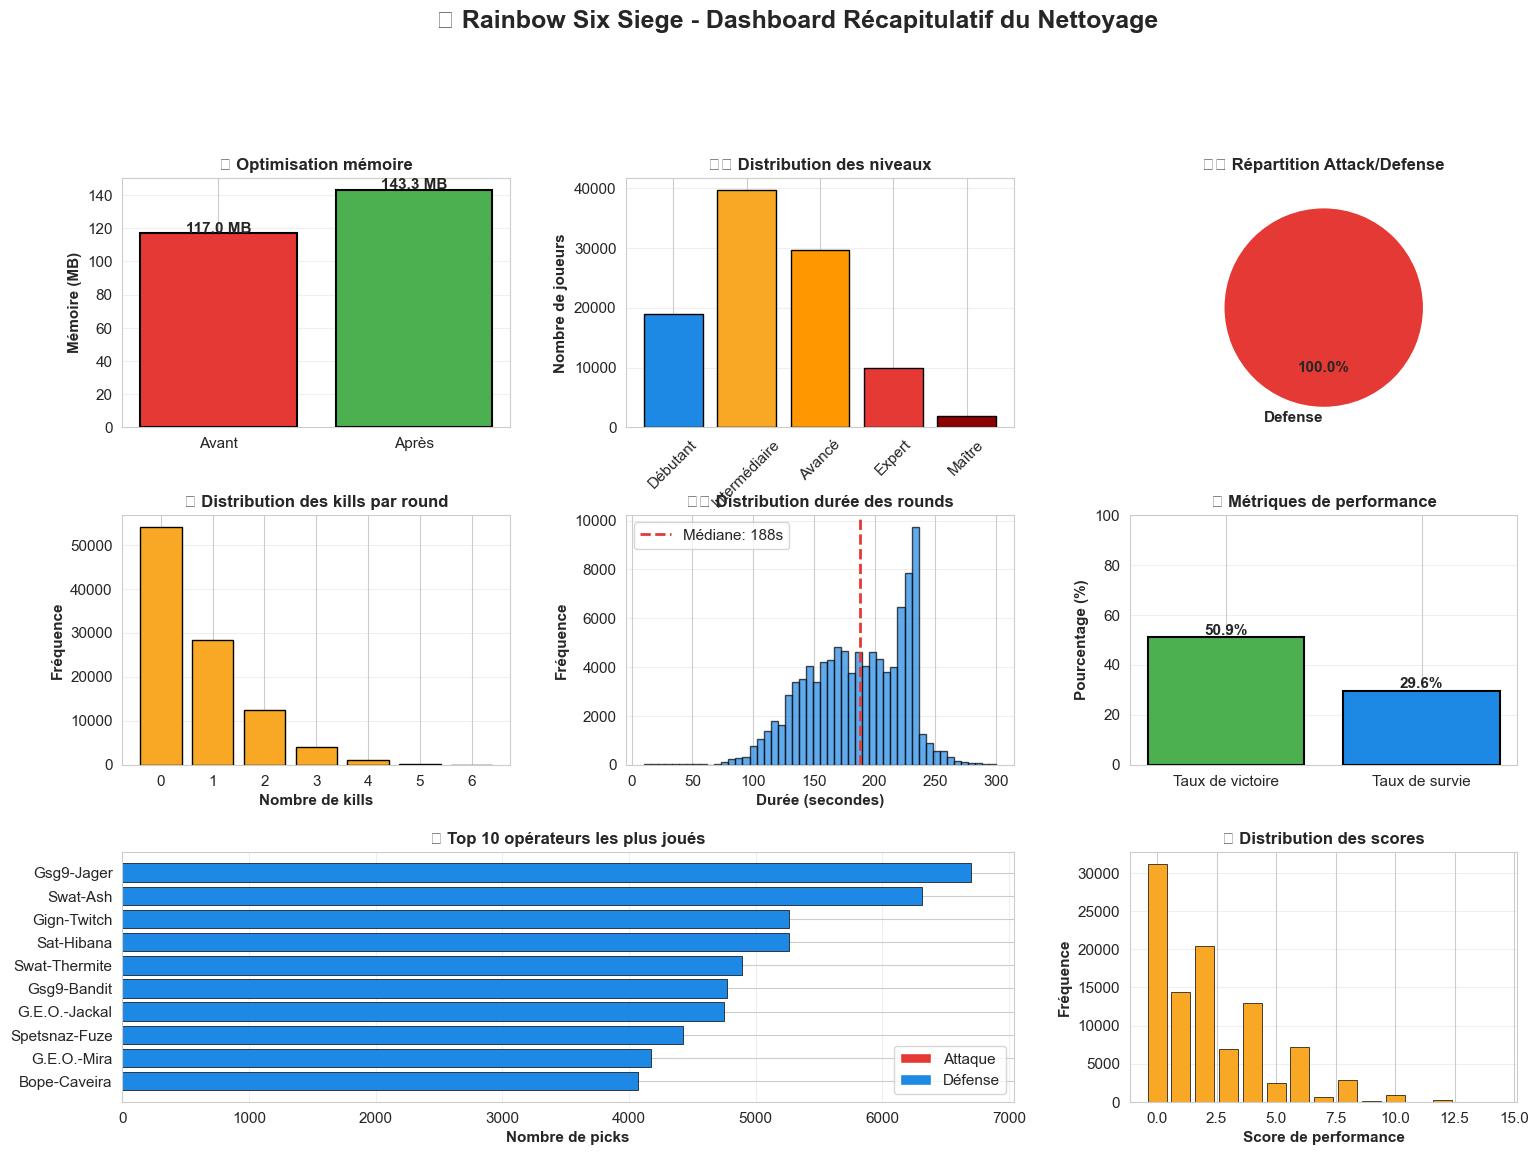


💾 Dashboard sauvegardé : ..\data\processed\cleaning_dashboard.png


In [28]:
# ═══════════════════════════════════════════════════════════════════════════
# 📊 DASHBOARD RÉCAPITULATIF DU NETTOYAGE
# ═══════════════════════════════════════════════════════════════════════════

fig = plt.figure(figsize=(18, 12))

# Définir la grille de sous-graphiques
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 1 : Comparaison mémoire avant/après
# ─────────────────────────────────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])

memory_data = {
    'État': ['Avant', 'Après'],
    'Mémoire (MB)': [
        df_raw.memory_usage(deep=True).sum() / 1024**2,
        df.memory_usage(deep=True).sum() / 1024**2
    ]
}

bars = ax1.bar(memory_data['État'], memory_data['Mémoire (MB)'], 
               color=[COLORS['danger'], COLORS['success']], 
               edgecolor='black', linewidth=1.5)

for bar, val in zip(bars, memory_data['Mémoire (MB)']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f} MB', ha='center', fontweight='bold', fontsize=11)

ax1.set_ylabel('Mémoire (MB)', fontweight='bold')
ax1.set_title('💾 Optimisation mémoire', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 2 : Distribution des niveaux de joueurs
# ─────────────────────────────────────────────────────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])

if 'level_category' in df.columns:
    level_order = ['Débutant', 'Intermédiaire', 'Avancé', 'Expert', 'Maître']
    level_counts = df['level_category'].value_counts().reindex(level_order).dropna()
    
    colors_level = [COLORS['info'], COLORS['primary'], COLORS['warning'], 
                   COLORS['danger'], '#8B0000'][:len(level_counts)]
    
    bars = ax2.bar(level_counts.index, level_counts.values, color=colors_level,
                   edgecolor='black', linewidth=1)
    
    ax2.set_ylabel('Nombre de joueurs', fontweight='bold')
    ax2.set_title('🎖️ Distribution des niveaux', fontweight='bold', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 3 : Répartition Attack/Defense (CORRIGÉ)
# ─────────────────────────────────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[0, 2])

if 'operator_side' in df.columns:
    side_counts = df['operator_side'].value_counts()
    n_categories = len(side_counts)
    
    # Créer les couleurs et explode dynamiquement selon le nombre de catégories
    pie_colors = [COLORS['danger'], COLORS['info']][:n_categories]
    pie_explode = [0.05] * n_categories  # Dynamique selon le nombre de catégories
    
    wedges, texts, autotexts = ax3.pie(
        side_counts.values,
        labels=side_counts.index,
        colors=pie_colors,
        autopct='%1.1f%%',
        startangle=90,
        explode=pie_explode,
        textprops={'fontweight': 'bold'}
    )
    
    ax3.set_title('⚔️ Répartition Attack/Defense', fontweight='bold', fontsize=12)
else:
    ax3.text(0.5, 0.5, 'Colonne operator_side\nnon disponible', 
             ha='center', va='center', fontsize=12)
    ax3.set_title('⚔️ Répartition Attack/Defense', fontweight='bold', fontsize=12)

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 4 : Distribution des kills
# ─────────────────────────────────────────────────────────────────────────────
ax4 = fig.add_subplot(gs[1, 0])

if 'nb_kills' in df.columns:
    kill_counts = df['nb_kills'].value_counts().sort_index()
    
    ax4.bar(kill_counts.index, kill_counts.values, color=COLORS['primary'],
            edgecolor='black', linewidth=1)
    
    ax4.set_xlabel('Nombre de kills', fontweight='bold')
    ax4.set_ylabel('Fréquence', fontweight='bold')
    ax4.set_title('🎯 Distribution des kills par round', fontweight='bold', fontsize=12)
    ax4.grid(axis='y', alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Colonne nb_kills\nnon disponible', 
             ha='center', va='center', fontsize=12)

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 5 : Distribution durée des rounds
# ─────────────────────────────────────────────────────────────────────────────
ax5 = fig.add_subplot(gs[1, 1])

if 'round_duration' in df.columns:
    ax5.hist(df['round_duration'].dropna(), bins=50, color=COLORS['info'], 
             edgecolor='black', alpha=0.7)
    
    # Ajouter ligne médiane
    median_duration = df['round_duration'].median()
    ax5.axvline(median_duration, color=COLORS['danger'], linestyle='--', 
                linewidth=2, label=f'Médiane: {median_duration:.0f}s')
    
    ax5.set_xlabel('Durée (secondes)', fontweight='bold')
    ax5.set_ylabel('Fréquence', fontweight='bold')
    ax5.set_title('⏱️ Distribution durée des rounds', fontweight='bold', fontsize=12)
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'Colonne round_duration\nnon disponible', 
             ha='center', va='center', fontsize=12)

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 6 : Taux de victoire et de survie
# ─────────────────────────────────────────────────────────────────────────────
ax6 = fig.add_subplot(gs[1, 2])

if 'has_won' in df.columns and 'is_dead' in df.columns:
    metrics = {
        'Taux de victoire': df['has_won'].mean() * 100,
        'Taux de survie': (1 - df['is_dead'].mean()) * 100
    }
    
    bars = ax6.bar(metrics.keys(), metrics.values(), 
                   color=[COLORS['success'], COLORS['info']],
                   edgecolor='black', linewidth=1.5)
    
    for bar, val in zip(bars, metrics.values()):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{val:.1f}%', ha='center', fontweight='bold', fontsize=11)
    
    ax6.set_ylabel('Pourcentage (%)', fontweight='bold')
    ax6.set_title('📈 Métriques de performance', fontweight='bold', fontsize=12)
    ax6.set_ylim(0, 100)
    ax6.grid(axis='y', alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'Colonnes has_won/is_dead\nnon disponibles', 
             ha='center', va='center', fontsize=12)

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 7 : Top 10 opérateurs les plus joués
# ─────────────────────────────────────────────────────────────────────────────
ax7 = fig.add_subplot(gs[2, :2])

if 'operator_name' in df.columns:
    top_operators = df['operator_name'].value_counts().head(10)
    
    # Liste des attaquants connus
    attackers_list = [
        'Ash', 'Thermite', 'Twitch', 'Sledge', 'Hibana', 'Buck', 
        'Thatcher', 'Blackbeard', 'Capitao', 'Jackal', 'Ying', 
        'Zofia', 'Dokkaebi', 'Lion', 'Finka', 'Glaz', 'Fuze', 
        'Blitz', 'Iq', 'Montagne'
    ]
    
    # Couleurs selon le côté
    colors_op = []
    for op in top_operators.index:
        if op in attackers_list:
            colors_op.append(COLORS['danger'])  # Attaque = Rouge
        else:
            colors_op.append(COLORS['info'])  # Défense = Bleu
    
    bars = ax7.barh(top_operators.index[::-1], top_operators.values[::-1], 
                    color=colors_op[::-1], edgecolor='black', linewidth=0.5)
    
    ax7.set_xlabel('Nombre de picks', fontweight='bold')
    ax7.set_title('🏆 Top 10 opérateurs les plus joués', fontweight='bold', fontsize=12)
    ax7.grid(axis='x', alpha=0.3)
    
    # Légende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLORS['danger'], label='Attaque'),
        Patch(facecolor=COLORS['info'], label='Défense')
    ]
    ax7.legend(handles=legend_elements, loc='lower right')
else:
    ax7.text(0.5, 0.5, 'Colonne operator_name non disponible', 
             ha='center', va='center', fontsize=12)

# ─────────────────────────────────────────────────────────────────────────────
# GRAPHIQUE 8 : Score de performance
# ─────────────────────────────────────────────────────────────────────────────
ax8 = fig.add_subplot(gs[2, 2])

if 'performance_score' in df.columns:
    score_counts = df['performance_score'].value_counts().sort_index()
    
    ax8.bar(score_counts.index, score_counts.values, color=COLORS['primary'],
            edgecolor='black', linewidth=0.5)
    
    ax8.set_xlabel('Score de performance', fontweight='bold')
    ax8.set_ylabel('Fréquence', fontweight='bold')
    ax8.set_title('⭐ Distribution des scores', fontweight='bold', fontsize=12)
    ax8.grid(axis='y', alpha=0.3)
else:
    ax8.text(0.5, 0.5, 'Colonne performance_score\nnon disponible', 
             ha='center', va='center', fontsize=12)

# ─────────────────────────────────────────────────────────────────────────────
# TITRE PRINCIPAL
# ─────────────────────────────────────────────────────────────────────────────
fig.suptitle('🎮 Rainbow Six Siege - Dashboard Récapitulatif du Nettoyage', 
             fontsize=18, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(PROCESSED_PATH / 'cleaning_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Dashboard sauvegardé : {PROCESSED_PATH / 'cleaning_dashboard.png'}")


In [26]:
# ═══════════════════════════════════════════════════════════════════════════
# 🎉 MESSAGE FINAL
# ═══════════════════════════════════════════════════════════════════════════

print("\n")
print("╔" + "═"*78 + "╗")
print("║" + " "*78 + "║")
print("║" + "🎉 NETTOYAGE TERMINÉ AVEC SUCCÈS !".center(78) + "║")
print("║" + " "*78 + "║")
print("╠" + "═"*78 + "╣")
print("║" + " "*78 + "║")
print("║" + "📁 Fichiers créés dans data/processed/ :".center(78) + "║")
print("║" + "   • r6siege_cleaned.csv".center(78) + "║")
print("║" + "   • r6siege_cleaned.parquet".center(78) + "║")
print("║" + "   • cleaning_report.json".center(78) + "║")
print("║" + "   • cleaning_dashboard.png".center(78) + "║")
print("║" + "   • missing_values_analysis.png".center(78) + "║")
print("║" + "   • outliers_detection.png".center(78) + "║")
print("║" + " "*78 + "║")
print("╠" + "═"*78 + "╣")
print("║" + " "*78 + "║")
print("║" + "🚀 Prochaines étapes :".center(78) + "║")
print("║" + "   1. Exécuter sql/schema.sql dans MySQL Workbench".center(78) + "║")
print("║" + "   2. Charger les données avec scripts/load_to_mysql.py".center(78) + "║")
print("║" + "   3. Créer le dashboard Power BI".center(78) + "║")
print("║" + " "*78 + "║")
print("╚" + "═"*78 + "╝")



╔══════════════════════════════════════════════════════════════════════════════╗
║                                                                              ║
║                      🎉 NETTOYAGE TERMINÉ AVEC SUCCÈS !                       ║
║                                                                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║                   📁 Fichiers créés dans data/processed/ :                    ║
║                              • r6siege_cleaned.csv                           ║
║                            • r6siege_cleaned.parquet                         ║
║                             • cleaning_report.json                           ║
║                            • cleaning_dashboard.png                          ║
║                          • missing_values_analysis.png                       ║
║                         